# Validation of Trained All IBD Fatigue ML Model on Scottish Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import keras
import numpy as np
import pickle
import shap
import pickle
import statsmodels.api as sm
from pathlib import Path

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

from src.data.loading import load_dnn_model
from src.data.preprocessing import map_season, fill_missing_values_with_saved_medians
from src.data.conversions import (
    capitalize_first_letter,
)
from src.config.constants import NUMERICAL_FEATURES
from src.config.paths import DNN_DIR, BENCHMARKING_DIR
from src.visualization.plotting import plot_missing_data_heatmap

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel(
    "data/fatigue_ml_data_validation_scotland.xlsx", sheet_name="fatigue_validation"
)

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
target_df = pd.read_csv(DNN_DIR / "exports" / "X_test.csv")

In [4]:
# Load the model, scaler, and explainer
model, scaler, explainer = load_dnn_model(model_date="2025-04-24")

## Transform Excel Data to Match Input DataFrame

In [5]:
# Strip whitespace from values in the following columns
cols_to_strip_whitespace = [
    "sex",
    "smoking_status",
    "montreal_cd_location",
    "montreal_cd_behaviour",
    "montreal_uc_severity",
    "montreal_uc_extent",
]

for col in cols_to_strip_whitespace:
    df[col] = df[col].astype(str).str.strip()

In [6]:
df["smoking_status"].value_counts()

# Remove (vape) from suffix
df["smoking_status"] = df["smoking_status"].str.replace(r"\s*\(vape\)", "", regex=True)
df["smoking_status"].value_counts()

# Map the smoking values
df["smoking_status"] = df["smoking_status"].map(
    {
        "Non smoker": "Non-smoker",
        "Ex smoker": "Ex-smoker",
        "Current smoker": "Smoker",
        "Smoker": "Smoker",
    }
)
df["smoking_status"].value_counts()

smoking_status
Non-smoker    46
Ex-smoker     11
Smoker         4
Name: count, dtype: int64

In [7]:
df["fatigue_outcome"] = df[
    "On how many days over the last 14 days have you felt fatigued? (0-14)"
].apply(lambda x: 1 if x >= 10 else 0)

In [8]:
# Transform Excel File into the same shape as the data used for the ml model
df["sex"] = df["sex"].map({"Male": 1, "Female": 0})

In [9]:
cols_to_rename = {
    "height_cm": "height",
    "weight_kg": "weight",
    "has_symptoms_of_active_ibd": "has_active_symptoms",
    "sampling_aminosalicylates (any)": "sampling_asa",
    "sampling_antibiotics": "sampling_abx",
    "study_group": "study_group_name",
    "smoking_status": "is_smoker",
    "Date Referred": "date_recorded",
}

df.rename(columns=cols_to_rename, inplace=True)

In [10]:
df["bmi"] = df["weight"] / ((df["height"] / 100) ** 2)

In [11]:
# calculate age at diagnosis based on age this year 2025, minus the year of date_of_diagnosis
df["age_at_diagnosis"] = df["age"] - (2025 - df["date_of_diagnosis"].dt.year)

# Feature Engineering Matching Up to Data Preprocessing Notebook

In [12]:
# Match up with 2_ml_data_preprocessing.py

df["disease_duration_weeks"] = (
    df["date_recorded"] - df["date_of_diagnosis"]
).dt.days / 7
df["season"] = df["date_recorded"].apply(map_season)
df["diagnosis_year"] = df["date_of_diagnosis"].dt.year

In [13]:
# Remove < from calprotectin
df["calprotectin"] = df["calprotectin"].astype(str).str.replace("<", "")
# Convert calprotectin to float
df["calprotectin"] = df["calprotectin"].astype(float)

In [14]:
# Ensure study_group_name is a string
df["study_group_name"] = df["study_group_name"].astype(str)
df["study_group_name"] = df["study_group_name"].apply(lambda x: x.upper())

In [15]:
# Change Yes and No to 1 and 0 for the following columns
cols_to_map = [
    "montreal_upper_gi",
    "montreal_perianal",
    "sampling_steroids",
    "sampling_abx",
    "sampling_asa",
    "sampling_aza",
    "sampling_mp",
    "sampling_ifx",
    "sampling_ada",
    "sampling_vedo",
    "sampling_uste",
    "sampling_tofa",
    "sampling_mtx",
    "sampling_ciclosporin",
    "sampling_filgo",
    "sampling_upa",
    "sampling_risa",
    "has_active_symptoms",
]

for col in cols_to_map:
    df[col] = df[col].map({"Yes": 1, "No": 0})

In [16]:
df["montreal_uc_extent"].value_counts()

df["montreal_uc_extent"] = df["montreal_uc_extent"].replace(
    {
        "E2": "E2 Left-sided",
    }
)
df["montreal_uc_extent"].value_counts()

montreal_uc_extent
nan              42
E3 Extensive      9
E1 Proctitis      6
E2 Left-sided     4
Name: count, dtype: int64

In [17]:
df["montreal_cd_behaviour"].value_counts()

montreal_cd_behaviour
B1 Non-stricturing, non-penetrating    30
nan                                    21
B2 Stricturing                          5
B3 Penetrating                          5
Name: count, dtype: int64

In [18]:
df["montreal_cd_behaviour"].value_counts()

montreal_cd_behaviour
B1 Non-stricturing, non-penetrating    30
nan                                    21
B2 Stricturing                          5
B3 Penetrating                          5
Name: count, dtype: int64

In [19]:
df["montreal_cd_location"].value_counts()


montreal_cd_location
L3 Ileocolonic    21
nan               21
L2 Colonic        10
L1 Ileal           9
Name: count, dtype: int64

In [20]:
# Capitalize the first letter in smoking_status
df["is_smoker"] = df["is_smoker"].apply(capitalize_first_letter)

In [21]:
medians_path = DNN_DIR / "exports" / "medians.json"
df = fill_missing_values_with_saved_medians(df, medians_path=medians_path)

### One-Hot Encoding of Categorical Variables

In [22]:
cols_to_fix_nans = [
    "montreal_cd_location",
    "montreal_cd_behaviour",
    "montreal_uc_severity",
    "montreal_uc_extent",
    "study_group_name",
]

# replace nan values with np.nan
for col in cols_to_fix_nans:
    df[col] = df[col].replace("nan", np.nan)
    df[col] = df[col].replace("NaN", np.nan)
    df[col] = df[col].replace("NAN", np.nan)


In [23]:
categorical_features_for_one_hot_encoding = [
    "study_group_name",
    "montreal_cd_location",
    "montreal_cd_behaviour",
    "montreal_uc_extent",
    "montreal_uc_severity",
    "is_smoker",
    "season",
]

df = pd.get_dummies(df, columns=categorical_features_for_one_hot_encoding, dtype=int)

### Fill in empty seasons

In [24]:
# check if season_autumn, season_summer, season_winter, season_spring are in the columns, if not in columns create it and fill with 0

for season in ["autumn", "summer", "winter", "spring"]:
    if f"season_{season}" not in df.columns:
        df[f"season_{season}"] = 0
        df[f"season_{season}"] = df[f"season_{season}"].astype(int)

In [25]:
cols_to_drop = [
    "Who collected this data",
    "Clinical Setting (inpatient, outpatient, endoscopy, infusion unit, etc.)",
    "On how many days over the last 14 days have you felt fatigued? (0-14)",
    "date_of_diagnosis",
    "date_recorded",
]

# Drop columns that are not needed
df.drop(columns=cols_to_drop, inplace=True)

In [26]:
# Add this columns as no patients had these features
cols_to_add = [
    "montreal_uc_severity_S3 Severe",
    "montreal_uc_severity_S2 Moderate",
]
for col in cols_to_add:
    if col not in df.columns:
        df[col] = 0
        df[col] = df[col].astype(int)

In [27]:
# Compare columns in df and target_df
# Check for columns in df that are not in target_df
df_columns_not_in_target_df = set(df.columns) - set(target_df.columns)

print("Columns in df that are not in target_df:" + str(df_columns_not_in_target_df))
target_df_columns_not_in_df = set(target_df.columns) - set(df.columns)
print("Columns in target_df that are not in df:" + str(target_df_columns_not_in_df))


Columns in df that are not in target_df:{'fatigue_outcome'}
Columns in target_df that are not in df:set()


## Check for Missing Data

In [28]:
nans_to_fill_with_zero = [
    "montreal_upper_gi",
    "montreal_perianal",
    "sampling_steroids",
    "sampling_abx",
    "sampling_asa",
    "sampling_aza",
    "sampling_mp",
    "sampling_ifx",
    "sampling_ada",
    "sampling_vedo",
    "sampling_uste",
    "sampling_tofa",
    "sampling_mtx",
    "sampling_ciclosporin",
    "sampling_filgo",
    "sampling_upa",
    "sampling_risa",
    "has_active_symptoms",
]

# Fill NaN values with 0
for col in nans_to_fill_with_zero:
    df[col] = df[col].fillna(0)

In [29]:
# Temp fix to delete later

# Fill missing sex with 1
df["sex"] = df["sex"].fillna(1)

## Create X_scotland and y_scotland DataFrames

Perform checking to ensure they match input dataframe

In [30]:
# Create Y_scotland
y_scotland = df["fatigue_outcome"].copy()
X_scotland = df.drop(columns=["fatigue_outcome"]).copy()
X_scotland = X_scotland[target_df.columns]

# Verify columns match
assert set(X_scotland.columns) == set(target_df.columns), "Columns do not match!"

In [31]:
# Check if column order matches
columns_match = all(
    X_scotland.columns[i] == target_df.columns[i]
    for i in range(len(X_scotland.columns))
)
print(f"Column order matches: {columns_match}")

Column order matches: True


In [32]:
# Ensure datatypes match
for col in X_scotland.columns:
    X_scotland[col] = X_scotland[col].astype(target_df[col].dtype)

# Verify all data types match
print("\nChecking data types match:")
mismatched_types = [
    (col, X_scotland[col].dtype, target_df[col].dtype)
    for col in X_scotland.columns
    if X_scotland[col].dtype != target_df[col].dtype
]
if mismatched_types:
    print("Mismatched types:", mismatched_types)
else:
    print("All data types match!")


Checking data types match:
All data types match!


## Scale Data

In [33]:
numerical_features = [
    col
    for col in NUMERICAL_FEATURES
    if col not in ["haematocrit", "ada_drug_level", "ifx_drug_level"]
]

# Apply the same scaling
X_scotland[numerical_features] = scaler.transform(X_scotland[numerical_features])

## Load the Keras Model

In [34]:
# Get probability predictions
y_pred_proba = model.predict(X_scotland)
# Get binary predictions using 0.5 threshold
y_pred = (y_pred_proba >= 0.5).astype(int)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_scotland, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.75      0.62        28
           1       0.67      0.42      0.52        33

    accuracy                           0.57        61
   macro avg       0.60      0.59      0.57        61
weighted avg       0.60      0.57      0.56        61



In [35]:
try:
    with open(BENCHMARKING_DIR / "statsmodels_logreg.pkl", "rb") as f:
        logreg_model = pickle.load(f)

    # Prepare data for statsmodels prediction (add constant if needed)
    X_scotland_const = sm.add_constant(X_scotland)

    # Ensure columns match the model's exog_names, adding missing ones with 0 if necessary
    missing_cols = set(logreg_model.params.index) - set(X_scotland_const.columns)
    for c in missing_cols:
        X_scotland_const[c] = 0
    # Ensure the order of columns matches the model's parameters
    X_scotland_const = X_scotland_const[logreg_model.params.index]

    # Get probability predictions for Logistic Regression model
    y_pred_proba_logreg = logreg_model.predict(X_scotland_const)

    # Calculate ROC curve and AUC for Logistic Regression model
    fpr_logreg, tpr_logreg, _ = roc_curve(y_scotland, y_pred_proba_logreg)
    roc_auc_logreg = auc(fpr_logreg, tpr_logreg)

    logreg_loaded = True
except FileNotFoundError:
    print(
        "\\nWarning: Logistic regression model file not found at output/statsmodels/stasmodels_logreg.pkl"
    )
    logreg_loaded = False
except Exception as e:
    print(f"\\nError loading or predicting with logistic regression model: {e}")
    logreg_loaded = False

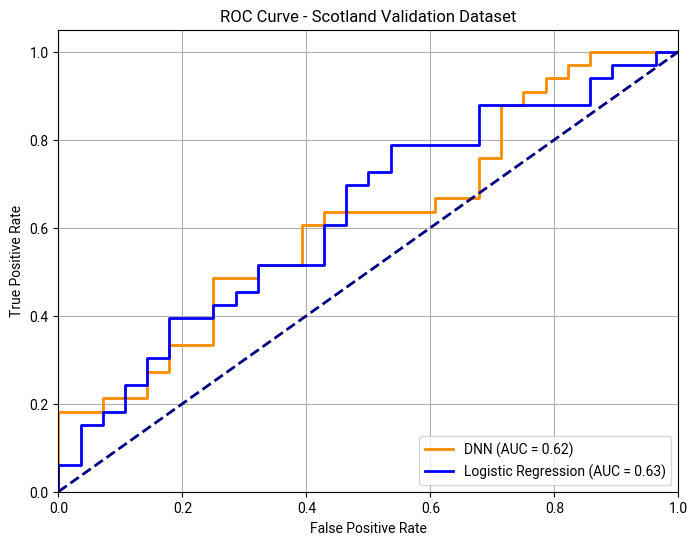

AUC Score (Keras DNN): 0.618
AUC Score (Logistic Regression): 0.629


In [36]:
# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_scotland, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"DNN (AUC = {roc_auc:.2f})")

# Plot Logistic Regression ROC if loaded successfully
if logreg_loaded:
    plt.plot(
        fpr_logreg,
        tpr_logreg,
        color="blue",
        lw=2,
        label=f"Logistic Regression (AUC = {roc_auc_logreg:.2f})",
    )

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Scotland Validation Dataset")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC score for Keras model
print(f"AUC Score (Keras DNN): {roc_auc:.3f}")
# Print AUC score for Logistic Regression model if loaded
if logreg_loaded:
    print(f"AUC Score (Logistic Regression): {roc_auc_logreg:.3f}")

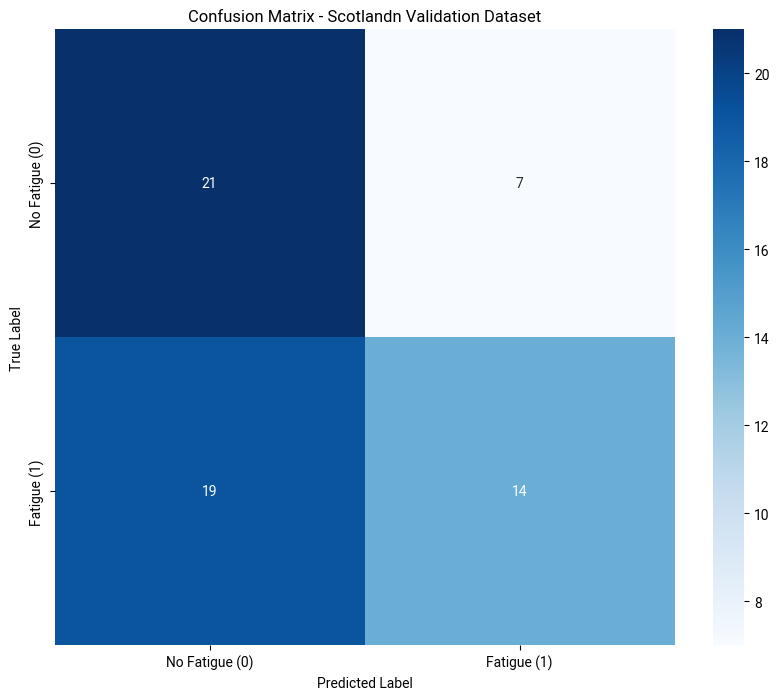


Detailed Confusion Matrix Interpretation:
True Negatives (Correctly predicted no fatigue): 21
False Positives (Incorrectly predicted fatigue): 7
False Negatives (Incorrectly predicted no fatigue): 19
True Positives (Correctly predicted fatigue): 14

Key Metrics:
Specificity (True Negative Rate): 0.750
Sensitivity (True Positive Rate): 0.424
Positive Predictive Value: 0.667
Negative Predictive Value: 0.525


In [37]:
# Create and plot confusion matrix with labels
cm = confusion_matrix(y_scotland, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Fatigue (0)", "Fatigue (1)"],
    yticklabels=["No Fatigue (0)", "Fatigue (1)"],
)
plt.title("Confusion Matrix - Scotlandn Validation Dataset")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Calculate and display detailed metrics
tn, fp, fn, tp = cm.ravel()
print("\nDetailed Confusion Matrix Interpretation:")
print(f"True Negatives (Correctly predicted no fatigue): {tn}")
print(f"False Positives (Incorrectly predicted fatigue): {fp}")
print(f"False Negatives (Incorrectly predicted no fatigue): {fn}")
print(f"True Positives (Correctly predicted fatigue): {tp}")

# Calculate additional metrics
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
ppv = tp / (tp + fp)
npv = tn / (tn + fn)

print("\nKey Metrics:")
print(f"Specificity (True Negative Rate): {specificity:.3f}")
print(f"Sensitivity (True Positive Rate): {sensitivity:.3f}")
print(f"Positive Predictive Value: {ppv:.3f}")
print(f"Negative Predictive Value: {npv:.3f}")

## Interrogate Confusion Matrix

In [38]:
# Create masks for each category based on actual and predicted values
# Need to flatten y_pred since it might have an extra dimension
y_pred_flat = y_pred.flatten()
true_positive_mask = (y_scotland == 1) & (y_pred_flat == 1)
true_negative_mask = (y_scotland == 0) & (y_pred_flat == 0)
false_positive_mask = (y_scotland == 0) & (y_pred_flat == 1)
false_negative_mask = (y_scotland == 1) & (y_pred_flat == 0)

# Create separate dataframes
tp_df = X_scotland[true_positive_mask].copy()
tn_df = X_scotland[true_negative_mask].copy()
fp_df = X_scotland[false_positive_mask].copy()
fn_df = X_scotland[false_negative_mask].copy()

# Verify the numbers match the confusion matrix
print("Dataset sizes:")
print(f"True Positives: {len(tp_df)}")
print(f"True Negatives: {len(tn_df)}")
print(f"False Positives: {len(fp_df)}")
print(f"False Negatives: {len(fn_df)}")

Dataset sizes:
True Positives: 14
True Negatives: 21
False Positives: 7
False Negatives: 19


In [39]:
shap_values = explainer.shap_values(fn_df)
shap_values_class_1 = shap_values[:, :, 0]
fn_df[numerical_features] = scaler.inverse_transform(fn_df[numerical_features])

100%|██████████| 19/19 [00:15<00:00,  1.23it/s]


In [40]:
# for i in range(len(fn_df)):
#     shap.force_plot(
#         explainer.expected_value[0],
#         shap_values_class_1[i],
#         fn_df.iloc[i],
#         matplotlib=True,
#         contribution_threshold=0.05,
#         text_rotation=30,
#         show=False,
#         plot_cmap="PRGn",
#     )
#     plt.show()

## Compare ML model vs Log Reg Model on this Cohort

In [41]:
if not logreg_loaded:
    print(
        "Logistic regression model was not loaded. Cannot compare misclassifications."
    )
else:
    # --- Get Binary Predictions ---
    # Keras DNN predictions (already calculated as y_pred)
    y_pred_dnn = y_pred.flatten()  # Ensure it's a 1D array

    # Logistic Regression predictions
    y_pred_logreg = (y_pred_proba_logreg >= 0.5).astype(int)

    # --- Identify Classifications for Each Model ---
    # Using the index of the X_scotland DataFrame to identify participants
    participant_indices = X_scotland.index

    # Keras DNN
    tp_dnn_indices = participant_indices[(y_scotland == 1) & (y_pred_dnn == 1)]
    tn_dnn_indices = participant_indices[(y_scotland == 0) & (y_pred_dnn == 0)]
    fp_dnn_indices = participant_indices[(y_scotland == 0) & (y_pred_dnn == 1)]
    fn_dnn_indices = participant_indices[(y_scotland == 1) & (y_pred_dnn == 0)]

    # Logistic Regression
    tp_logreg_indices = participant_indices[(y_scotland == 1) & (y_pred_logreg == 1)]
    tn_logreg_indices = participant_indices[(y_scotland == 0) & (y_pred_logreg == 0)]
    fp_logreg_indices = participant_indices[(y_scotland == 0) & (y_pred_logreg == 1)]
    fn_logreg_indices = participant_indices[(y_scotland == 1) & (y_pred_logreg == 0)]

    # --- Compare True Positives ---
    tp_both = tp_dnn_indices.intersection(tp_logreg_indices)
    tp_dnn_only = tp_dnn_indices.difference(tp_logreg_indices)
    tp_logreg_only = tp_logreg_indices.difference(tp_dnn_indices)

    print("\n--- True Positive Comparison ---")
    print(f"Total TP (DNN): {len(tp_dnn_indices)}")
    print(f"Total TP (LogReg): {len(tp_logreg_indices)}")
    print(f"TP identified by BOTH models: {len(tp_both)}")
    print(f"TP identified by DNN ONLY: {len(tp_dnn_only)}")
    print(f"TP identified by LogReg ONLY: {len(tp_logreg_only)}")

    # --- Compare True Negatives ---
    tn_both = tn_dnn_indices.intersection(tn_logreg_indices)
    tn_dnn_only = tn_dnn_indices.difference(tn_logreg_indices)
    tn_logreg_only = tn_logreg_indices.difference(tn_dnn_indices)

    print("\n--- True Negative Comparison ---")
    print(f"Total TN (DNN): {len(tn_dnn_indices)}")
    print(f"Total TN (LogReg): {len(tn_logreg_indices)}")
    print(f"TN identified by BOTH models: {len(tn_both)}")
    print(f"TN identified by DNN ONLY: {len(tn_dnn_only)}")
    print(f"TN identified by LogReg ONLY: {len(tn_logreg_only)}")

    # --- Compare False Positives ---
    fp_both = fp_dnn_indices.intersection(fp_logreg_indices)
    fp_dnn_only = fp_dnn_indices.difference(fp_logreg_indices)
    fp_logreg_only = fp_logreg_indices.difference(fp_dnn_indices)

    print("\n--- False Positive Comparison ---")
    print(f"Total FP (DNN): {len(fp_dnn_indices)}")
    print(f"Total FP (LogReg): {len(fp_logreg_indices)}")
    print(f"FP identified by BOTH models: {len(fp_both)}")
    print(f"FP identified by DNN ONLY: {len(fp_dnn_only)}")
    print(f"FP identified by LogReg ONLY: {len(fp_logreg_only)}")
    # Optional: print the actual indices if needed
    # print(f"FP Both Indices: {fp_both.tolist()}")
    # print(f"FP DNN Only Indices: {fp_dnn_only.tolist()}")
    # print(f"FP LogReg Only Indices: {fp_logreg_only.tolist()}")

    # --- Compare False Negatives ---
    fn_both = fn_dnn_indices.intersection(fn_logreg_indices)
    fn_dnn_only = fn_dnn_indices.difference(fn_logreg_indices)
    fn_logreg_only = fn_logreg_indices.difference(fn_dnn_indices)

    print("\n--- False Negative Comparison ---")
    print(f"Total FN (DNN): {len(fn_dnn_indices)}")
    print(f"Total FN (LogReg): {len(fn_logreg_indices)}")
    print(f"FN identified by BOTH models: {len(fn_both)}")
    print(f"FN identified by DNN ONLY: {len(fn_dnn_only)}")
    print(f"FN identified by LogReg ONLY: {len(fn_logreg_only)}")
    # Optional: print the actual indices if needed
    # print(f"FN Both Indices: {fn_both.tolist()}")
    # print(f"FN DNN Only Indices: {fn_dnn_only.tolist()}")
    # print(f"FN LogReg Only Indices: {fn_logreg_only.tolist()}")


--- True Positive Comparison ---
Total TP (DNN): 14
Total TP (LogReg): 13
TP identified by BOTH models: 11
TP identified by DNN ONLY: 3
TP identified by LogReg ONLY: 2

--- True Negative Comparison ---
Total TN (DNN): 21
Total TN (LogReg): 22
TN identified by BOTH models: 20
TN identified by DNN ONLY: 1
TN identified by LogReg ONLY: 2

--- False Positive Comparison ---
Total FP (DNN): 7
Total FP (LogReg): 6
FP identified by BOTH models: 5
FP identified by DNN ONLY: 2
FP identified by LogReg ONLY: 1

--- False Negative Comparison ---
Total FN (DNN): 19
Total FN (LogReg): 20
FN identified by BOTH models: 17
FN identified by DNN ONLY: 2
FN identified by LogReg ONLY: 3


In [42]:
# Add this at the end of the notebook
output_dir = Path("output/validation/scotland")
output_dir.mkdir(parents=True, exist_ok=True)

# Save X and y data
X_scotland.to_csv(output_dir / "X_scotland.csv", index=False)
pd.Series(y_scotland).to_csv(output_dir / "y_scotland.csv", index=False)
print(f"Saved preprocessed Scotland validation data to {output_dir}")

Saved preprocessed Scotland validation data to output/validation/scotland
